# 1 Проект `BigData_PySpark`

## 1.1. Название.

Прогнозирование количества заказов такси на следующий час в каждом из округов города Чикаго с помощью **Apache Spark**

## 1.2. Задача проекта.

* Имеется около 10 млн записей о поездках такси в городе Чикаго с округлением времени до 15 минут.   
  Благодарю специалистов **Яндекс.Практикума** за предоставленные датасеты.  
* Задача - предсказать количество заказов на следующий час в каждом округе города.   
* Решаем с применением **'PySpark'** в режиме 'standalone'.  

## 1.3. Описание данных.

В нашем распоряжении данные о поездках в Чикаго за 2022 и 2023 годы.
Описание данных по колонкам:
* `trip_id` - уникальный идентификатор поездки.
* `taxi_id` - уникальный идентификатор машины такси.
* `trip_start_timestamp` - время начала поездки.
* `trip_end_timestamp` - время окончания поездки.
* `trip_seconds` - длительность поездки в секундах.
* `trip_miles` - расстояние поездки в милях.
* `pickup_census_tract` - название зоны посадки.
* `dropoff_census_tract` - название зоны высадки.
* `pickup_community_area` - номер района посадки в Чикаго.
* `dropoff_community_area` - номер района высадки в Чикаго.
* `fare` - стоимость поездки.
* `tips` - чаевые водителю.
* `tolls` - сборы за платные участки дороги.
* `extras` - дополнительные сборы за поездку.
* `trip_total` - общая стоимость поездки.
* `payment_type` - тип оплаты.
* `company` - название компании такси.
* `pickup_centroid_latitude` - географическая широта зоны *посадки*.
* `pickup_centroid_longitude` - географическая долгота зоны *посадки*.
* `pickup_centroid_location` - координаты зоны *посадки*.
* `dropoff_centroid_latitude` - географическая широта зоны *высадки*.
* `dropoff_centroid_longitude` - географическая долгота зоны *высадки*. 
* `dropoff_centroid_location` - координаты зоны *высадки*. 

## 1.4. План работ.

1. Загрузить и изучить данные. 
2. Провести EDA анализ.
3. Провести Feature Engineering.
4. Обучить несколько моделей и сравнить результаты обучения.
5. Сделать сравнение и сформулировать выводы и рекомендации для применения.

# 2. Загрузка и исследование данных.

In [1]:
#!pip install pyspark 
#!pip install findspark

In [2]:
import os
import findspark
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F


from tqdm.auto import tqdm
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from datetime import timedelta, datetime
from pyspark.sql.functions import (col, lit, isnull, round,
                                   when, count, datediff,
                                   monotonically_increasing_id)

from pyspark.sql.window import Window
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


from pyspark.ml.regression import (LinearRegression, DecisionTreeRegressor,
                                   RandomForestRegressor, GBTRegressor)
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


# Введем глобальную переменные:
RANDOM_FIX_NUMBER = 12345  
NUMBER_CHICAGO_AREAS = 77

# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
# Ограничим ширину отображающихся столбцов
pd.options.display.max_colwidth = 50
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Настроим, чтобы числа в датасетах отражались с 2 знаками после запятой
pd.set_option('display.float_format', '{:.2f}'.format) 

## 2.1.Запуск SPARK-сессии.

In [3]:
findspark.init()

spark = SparkSession.builder.\
        master("local[*]").\
        appName("pyspark-taxi-forecasting").\
        getOrCreate()

spark

In [4]:
def load_dataset(file_name):
    '''
    Функция для проверки нахождения файла и загрузки датафрейма.
    '''
    if os.path.exists(file_name):
        # Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
        for _ in tqdm(range(1)): 
            data = spark.read.csv(file_name, 
                                  header=True, inferSchema=True)
            print('Dataset', file_name, 'is loaded successfully.')
        # Проверим исходный размер датасетов
        print(f'Количество записей в {file_name}: {data.count()}\n')
        return data
    else:
        print('Something with', file_name, 'is wrong.')
    
# Загрузка датасета с данными за 2022 год.
df2022 = load_dataset('Taxi_Trips_-_2022.csv');

# Загрузка датасета с данными за 2023 год.
df2023 = load_dataset('Taxi_Trips_-_2023.csv');

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset Taxi_Trips_-_2022.csv is loaded successfully.
Количество записей в Taxi_Trips_-_2022.csv: 6382425



  0%|          | 0/1 [00:00<?, ?it/s]

Dataset Taxi_Trips_-_2023.csv is loaded successfully.
Количество записей в Taxi_Trips_-_2023.csv: 3783730



**Промежуточные выводы:**  
В нашем распоряжении 2 датасета с информацией о заказах такси: 
* за 2022 год - 6 382 425 записей,
* за 2023 год - 3 783 730 записей. 

## 2.2.Объединение датасетов.

Прежде, чем провести объединение датасетов, проверим соответствие их признаков.

In [5]:
# Названия колонок в датасете 'df2022':
features2022 = df2022.columns
print(features2022)

# Названия колонок в датасете 'df2023':
features2023 = df2023.columns
print(features2023)

if (features2022 == features2023) :
    print('\nНазвания признаков обоих датасетов одинаковые.')
else:
    print('\nДатасеты имеют разные признаки!.'
          'Cледует изучить возможность их объединения!')

['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']
['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']

Названия признаков обоих датасетов одинаковые.


In [6]:
# Посмотрим данные в df2022
df2022.show(1, vertical=True)

-RECORD 0------------------------------------------
 Trip ID                    | bcfa19f2539021c05... 
 Taxi ID                    | 368ce5511598af2cc... 
 Trip Start Timestamp       | 01/01/2022 12:00:... 
 Trip End Timestamp         | 01/01/2022 12:00:... 
 Trip Seconds               | 152                  
 Trip Miles                 | 0.1                  
 Pickup Census Tract        | NULL                 
 Dropoff Census Tract       | NULL                 
 Pickup Community Area      | NULL                 
 Dropoff Community Area     | NULL                 
 Fare                       | 3.75                 
 Tips                       | 0.0                  
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 3.75                 
 Payment Type               | Cash                 
 Company                    | Medallion Leasin     
 Pickup Centroid Latitude   | NULL                 
 Pickup Cent

In [7]:
# Посмотрим данные в df2023
df2023.show(1, vertical=True)

-RECORD 0------------------------------------------
 Trip ID                    | 0fca59218b1168827... 
 Taxi ID                    | e2c349c7cbb608d55... 
 Trip Start Timestamp       | 01/01/2023 12:00:... 
 Trip End Timestamp         | 01/01/2023 12:15:... 
 Trip Seconds               | 1037                 
 Trip Miles                 | 4.82                 
 Pickup Census Tract        | NULL                 
 Dropoff Census Tract       | NULL                 
 Pickup Community Area      | 6                    
 Dropoff Community Area     | 32                   
 Fare                       | 15.75                
 Tips                       | 3.25                 
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 19.5                 
 Payment Type               | Credit Card          
 Company                    | Taxicab Insurance... 
 Pickup Centroid Latitude   | 41.944226601         
 Pickup Cent

**Отмечаем**, что признаки в обоих датасетах идентичны, значит, их можно объединять.

In [8]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)): 
    # Объединяем датасеты:
    data = df2022.union(df2023)

    # Проверка, нет ли пропущенных записей после объединения данных:
    if data.count() == df2022.count() + df2023.count():
        print('Данные объединены корректно, потерь нет.')
    else: 
        print('Данные объединены с потерями.')


    # Удалим промежуточные датасеты, чтобы высвободить память:
    del df2022
    del df2023

    full_data_size = data.count()
    print('\nРазмер объединенного датасета:', full_data_size, 'записей на',
          len(data.columns), 'признака.')

  0%|          | 0/1 [00:00<?, ?it/s]

Данные объединены корректно, потерь нет.

Размер объединенного датасета: 10166155 записей на 23 признака.


## 2.3. Приведём все названия колонок к стилю `snakecase`.

In [9]:
print(data.columns)

# Переведём все символы в нижний регистр
# и заменим пробелы на символы подчёркивания:
data = data.toDF(*[c.lower().replace(' ', '_') for c in data.columns])

print(data.columns)

['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']
['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid__location']


**Промежуточные выводы:**   
* Названия признаков приведены к стилю `snakecase`. Теперь к ним можно обращаться через точку.
* всего 23 признака, из них 8 типа 'string', остальные - числовые;
* признаки 'trip_start_timestamp' и 'trip_end_timestamp' нужно преобразовать к типу 'дата-время'
* Для решения поставленной задачи нам нужны всего 2 признака: `trip_start_timestamp` и `pickup_community_area`. Остальные можно удалить.

## 2.4. Удаление ненужных признаков.¶

In [10]:
columns_to_drop = ['trip_id', 'taxi_id', 'trip_end_timestamp', 
                   'trip_seconds', 'trip_miles', 'pickup_census_tract', 
                   'dropoff_census_tract', 'dropoff_community_area', 
                   'fare', 'tips', 'tolls', 'extras', 'trip_total', 
                   'payment_type', 'company', 'pickup_centroid_latitude', 
                   'pickup_centroid_longitude', 'pickup_centroid_location', 
                   'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 
                   'dropoff_centroid__location']
data = data.drop(*columns_to_drop)

In [11]:
# Признаки, оставленные в датасете:
print(data.columns)

['trip_start_timestamp', 'pickup_community_area']


## 2.5. Проверка и коррекция типов данных.

In [12]:
print(data.tail(1))
data.printSchema()

# Преобразование к типу 'дата-время'
data = data.withColumn('trip_start_timestamp', 
                       F.to_timestamp(F.col('trip_start_timestamp'),
                       'MM/dd/yyyy hh:mm:ss a'))

# Проверим типы данных
data.printSchema()
print(data.tail(1))

[Row(trip_start_timestamp='08/01/2023 12:00:00 AM', pickup_community_area=34)]
root
 |-- trip_start_timestamp: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)

root
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- pickup_community_area: integer (nullable = true)

[Row(trip_start_timestamp=datetime.datetime(2023, 8, 1, 0, 0), pickup_community_area=34)]


**Отмечаем**:  
признаки 'trip_start_timestamp' и 'trip_end_timestamp' успешно преобразованы к типу 'дата-время'.

## 2.6. Диапазон времени использования такси.

In [13]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    
    date_first = data.select(F.min('trip_start_timestamp')).first()[0]
    date_last = data.select(F.max('trip_start_timestamp')).first()[0]
        
    print('В БД находятся заказы такси, начиная с', 
          date_first, 'и до', date_last, 'продолжительностью', 
          "{} дней.".format((date_last - date_first).days))

  0%|          | 0/1 [00:00<?, ?it/s]

В БД находятся заказы такси, начиная с 2022-01-01 00:00:00 и до 2023-08-01 00:00:00 продолжительностью 577 дней.


## 2.7. Пропущенные значения.

In [14]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    for feature in data.columns:
        print(feature, data[data[feature].isNull()].count())

  0%|          | 0/1 [00:00<?, ?it/s]

trip_start_timestamp 0
pickup_community_area 681620


**Отмечаем**:
* в признаке 'trip_start_timestamp' нет пропущенных значений.
* в признаке 'pickup_community_area' пропущенных значений много, 681 620.

### 2.7.1. Пропущенные значения в признаке '*pickup_community_area*'.

In [15]:
# Количество значений в столбце `pickup_community_area`
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    community_area_count = data.select('pickup_community_area').\
                           distinct().count()
    print(f'Количество значений в столбце',
          f'`pickup_community_area`: {community_area_count}')

  0%|          | 0/1 [00:00<?, ?it/s]

Количество значений в столбце `pickup_community_area`: 78


**Отмечаем**, что в Чикаго всего 77 городских района. См: [Районы г Чикаго](https://en.wikipedia.org/wiki/Community_areas_in_Chicago "Жми на ссылку...").  
Посмотрим, почему у нас их получается 78?

In [16]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    print("Диапазон значений 'pickup_community_area' от",
          data.select(F.min('pickup_community_area')).first()[0],
          'и до', data.select(F.max('pickup_community_area')).first()[0])

  0%|          | 0/1 [00:00<?, ?it/s]

Диапазон значений 'pickup_community_area' от 1 и до 77


In [17]:
(data.groupby("pickup_community_area").
     agg(F.count("pickup_community_area")).show(15))

+---------------------+----------------------------+
|pickup_community_area|count(pickup_community_area)|
+---------------------+----------------------------+
|                   31|                       15211|
|                   65|                        3341|
|                   53|                       17653|
|                   34|                       26448|
|                   28|                      873134|
|                   76|                     1736750|
|                   27|                        8206|
|                   26|                        4023|
|                   44|                       44028|
|                   12|                       12810|
|                   22|                       48480|
|                   47|                        2860|
|                 NULL|                           0|
|                    1|                       56517|
|                   52|                        5446|
+---------------------+-----------------------

**Отмечаем**, что есть пропущенные значения.  
Предположим, что пропуски появились, когда такси работали за пределами города.  
В нашей задаче нужно предсказать количество заказов такси по РАЙОНАМ города, т.е., пригороды, имеющие огромную территорию, в задачу не входят.   
**Принимаем решение** удалить информацию по заказам из пригорода Чикаго.

In [18]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_cleaned = data.na.drop(how='any')

    num_data = data.count()
    num_cleaned_data = data_cleaned.count()
    
    # количество строк до и после удаления пропусков
    print(f'Количество строк до удаления пропусков: {num_data}')
    print(f'Количество строк после удаления пропусков: {num_cleaned_data}')
    print(f'Удельная часть удаленных записей: ' + 
          f'{(num_data-num_cleaned_data)/num_data:.2%}')
    
    if full_data_size - num_cleaned_data == 681620:
        print('\nДанные собраны корректно, потерь нет.')
    else: 
        print('\nДанные имеют потери!')
        
    print('Размер итогового датасета:', num_cleaned_data, 'записей на',
          len(data_cleaned.columns), 'признака.') 
    
    # Удалим ненужный более датасет, чтобы высвободить память:
    del data

  0%|          | 0/1 [00:00<?, ?it/s]

Количество строк до удаления пропусков: 10166155
Количество строк после удаления пропусков: 9484535
Удельная часть удаленных записей: 6.70%

Данные собраны корректно, потерь нет.
Размер итогового датасета: 9484535 записей на 2 признака.


## 2.8. Агрегация данных по 1 часу времени заказа.

In [19]:
# Дадим признакам более короткие названия:
data_cleaned = (data_cleaned.
               withColumnRenamed('trip_start_timestamp', 'datetime').
               withColumnRenamed('pickup_community_area', 'area')
               )

data_cleaned.show(100, truncate=False)

+-------------------+----+
|datetime           |area|
+-------------------+----+
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|7   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|77  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|56  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|2   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|22  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|25  |
|

**Отмечаем**, что данные содержат информацию по каждым 15 минутам заказов такси.   
Для нашей задачи нужна информация почасовая, поэтому округлим время до ближайшего часа.

In [20]:
data_cleaned = data_cleaned.withColumn('datetime', 
                                       F.date_trunc('hour', 'datetime'))

data_cleaned.show(100, truncate=False)

+-------------------+----+
|datetime           |area|
+-------------------+----+
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|7   |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|33  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|77  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|56  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|2   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|22  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|32  |
|2022-01-01 00:00:00|76  |
|2022-01-01 00:00:00|8   |
|2022-01-01 00:00:00|28  |
|2022-01-01 00:00:00|3   |
|2022-01-01 00:00:00|25  |
|

Подсчитаем количество заказов по каждому району Чикаго ежечасно.

In [21]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours = (data_cleaned.
                  groupBy('datetime', 'area').
                  agg(F.count('*').alias('count')).cache()
                 )
    data_hours.show(10)
    
    # Удалим ненужный более датасет, чтобы высвободить память:
    del data_cleaned

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 04:00:00|  14|    2|
|2022-01-01 05:00:00|  22|    3|
|2022-01-01 08:00:00|  28|    3|
|2022-01-01 08:00:00|  39|    1|
|2022-01-01 16:00:00|  44|    1|
|2022-01-01 17:00:00|  36|    4|
|2022-01-01 18:00:00|  13|    1|
|2022-01-02 08:00:00|  77|    4|
|2022-01-02 10:00:00|  48|    1|
|2022-01-02 10:00:00|  34|    2|
+-------------------+----+-----+
only showing top 10 rows



In [22]:
print('Таким образом, за вес период наблюдений у нас собрано',
      data_hours.count(), 'записей.')
print(date_first)
print(date_last)

print('\nС учетом 24 часа/день и на', NUMBER_CHICAGO_AREAS, 
      'районов города за этот период должно быть собрано',
      "{}".format((date_last - date_first).days * 24 * NUMBER_CHICAGO_AREAS),
      'записей.')

Таким образом, за вес период наблюдений у нас собрано 606065 записей.
2022-01-01 00:00:00
2023-08-01 00:00:00

С учетом 24 часа/день и на 77 районов города за этот период должно быть собрано 1066296 записей.


**Отмечаем**, что есть очень много попущенных значений, когда в каком-либо районе Чикаго не было заказов такси!

Отсортируем данные в хронологическом порядке:

In [23]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours.sort(['datetime'], ascending = True).show(10)
    
    print('Количество записей в отсортированном датасете:', 
          data_hours.count())
    
    print("Диапазон значений 'area' от",
          data_hours.select(F.min('area')).first()[0],
          'и до', data_hours.select(F.max('area')).first()[0])
    
    data_hours.show(5)

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 00:00:00|  11|    1|
|2022-01-01 00:00:00|  19|    1|
|2022-01-01 00:00:00|   3|    9|
|2022-01-01 00:00:00|  28|   42|
|2022-01-01 00:00:00|  33|    7|
|2022-01-01 00:00:00|  56|    8|
|2022-01-01 00:00:00|  25|    3|
|2022-01-01 00:00:00|  48|    1|
|2022-01-01 00:00:00|  24|   20|
|2022-01-01 00:00:00|  34|    1|
+-------------------+----+-----+
only showing top 10 rows

Количество записей в отсортированном датасете: 606065
Диапазон значений 'area' от 1 и до 77
+-------------------+----+-----+
|           datetime|area|count|
+-------------------+----+-----+
|2022-01-01 04:00:00|  14|    2|
|2022-01-01 05:00:00|  22|    3|
|2022-01-01 08:00:00|  28|    3|
|2022-01-01 08:00:00|  39|    1|
|2022-01-01 16:00:00|  44|    1|
+-------------------+----+-----+
only showing top 5 rows



**Промежуточные результаты**:
* Подготовлен датасет с признаками:
    * Время заказа такси с дискретностью в 1 час.
    * Номер района Чикаго (в диапазоне от 1 до 77).
    * Количество заказов по данному районе в течение часа.
* Данные отсортированы по времени заявки такси.   

# 3. EDA анализ.

In [24]:
# Посмотрим статистику по количеству заказов по округам и по дате.
data_hours.describe('count').show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            606065|
|   mean|15.649369292072633|
| stddev|45.441559182400965|
|    min|                 1|
|    max|               591|
+-------+------------------+



**Отмечаем**:
* Диапазон количества заказов по округам и по дате очень широкий: от 1 до 591.
* При значении STD равным 45, есть значения далеко за пределами 3-х сигма, что говорит о наличии аномальных значений.

## 3.1. Дополнительные признаки.

### 3.1.1. Распределение заказов такси по различным временным признакам.

In [25]:
for _ in tqdm(range(1)): # Чтобы видеть, что процесс выполняется
    data_hours = data_hours.withColumn('hour', F.hour('datetime'))
    data_hours = data_hours.withColumn('day_week', F.dayofweek('datetime'))
    data_hours = data_hours.withColumn('day_month', F.dayofmonth('datetime'))
    data_hours = data_hours.withColumn('month', F.month('datetime'))
    
    sort_hour = data_hours.groupby('hour').count().sort('hour').toPandas()
    sort_dayweek = data_hours.groupby('day_week').count().sort('day_week').toPandas()
    sort_daymonth = data_hours.groupby('day_month').count().sort('day_month').toPandas()
    sort_month = data_hours.groupby('month').count().sort('month').toPandas()

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
def visualization_datetime(data, x, x_name):
    plt.figure(figsize=(9, 3))
    sns.barplot(data = data, x = x, y = 'count')
    plt.xlabel(x_name, color = 'blue', size = 10)
    plt.ylabel('Количество заказов такси.', color='blue', size = 10)
    plt.title('Распределение количества заказов такси.',
              color='red', size = 12);

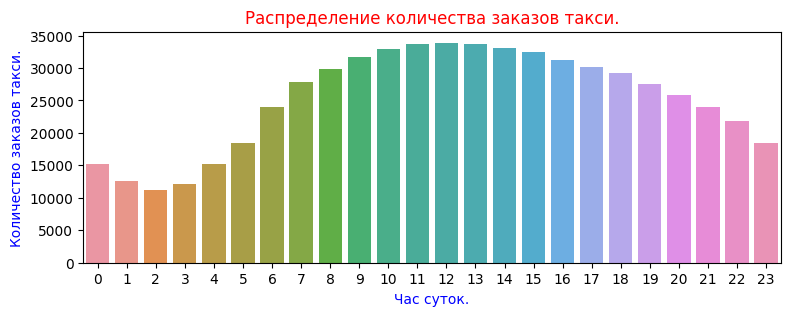

In [27]:
visualization_datetime(sort_hour, 'hour', 'Час суток.')

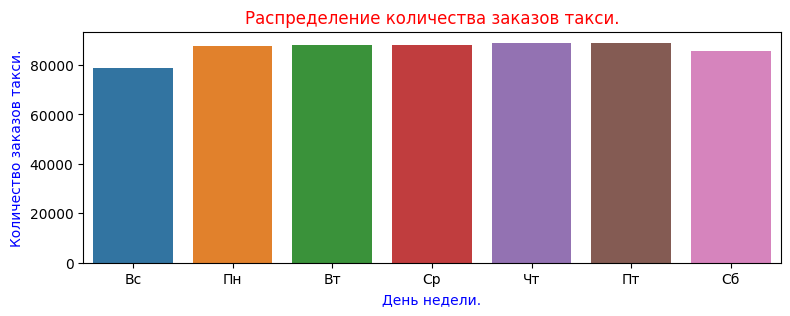

In [28]:
weekdays = ['Вс', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб']
visualization_datetime(sort_dayweek, weekdays, 'День недели.')

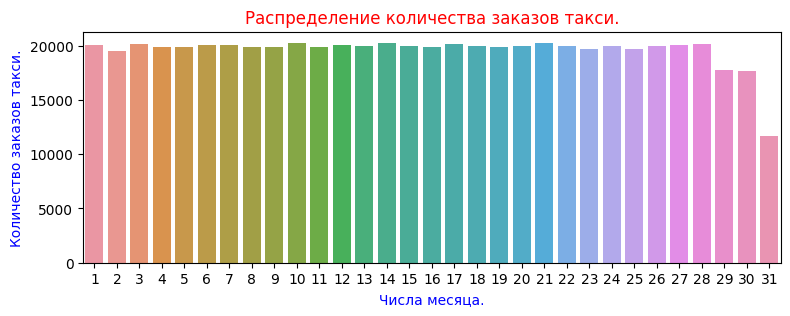

In [29]:
visualization_datetime(sort_daymonth, 'day_month', 'Числа месяца.')

In [ ]:
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июнь', 
          'Июль','Авг', 'Сен', 'Окт', 'Нояб', 'Дек']
visualization_datetime(sort_month, months, 'Месяц.')

**Промежуточные выводы**:
* Минимальное количество заказов такси приходится на ночные часы, и максимальное на дневные.
* Количество заказов растет с началом недели до пятницы. В выходние дни такси пользуются реже.
* По дням недели количество заказов довольно ровное. Отметим, что 31 день только примерно в каждом втором месяце.
* Зимой люди реже пользуются такси.

### 3.1.2. Распределение заказов такси по районам г. Чикаго.

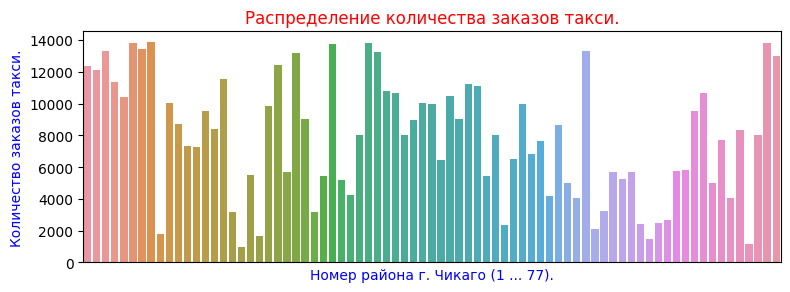

In [31]:
sort_area = data_hours.groupby('area').count().sort('area').toPandas()

plt.figure(figsize=(9, 3))
sns.barplot(data = sort_area, x = 'area', y = 'count')
plt.xlabel(f'Номер района г. Чикаго (1 ... {NUMBER_CHICAGO_AREAS}).', 
           color = 'blue', size = 10)
plt.ylabel('Количество заказов такси.', color='blue', size = 10)
plt.title('Распределение количества заказов такси.',
          color='red', size = 12)
plt.xticks([]);

del sort_area

**Промежуточные выводы**:
* Услугами такси пользуются во всех районах. Но неравномерно.
* Отношение максимального количества заказов к минимальному около 10.

### 3.1.3. Тренды и сезонность.

In [32]:
# Посмотрим наш дата сет
data_hours.show(2)

# Проверим датасет на наличие пропусков:
nacounts = (data_hours.
            select([count(when(isnull(c), c)).alias(c)
                    for c in data_hours.columns]).
            toPandas()
           )
nacounts

+-------------------+----+-----+----+--------+---------+-----+
|           datetime|area|count|hour|day_week|day_month|month|
+-------------------+----+-----+----+--------+---------+-----+
|2022-01-01 04:00:00|  14|    2|   4|       7|        1|    1|
|2022-01-01 05:00:00|  22|    3|   5|       7|        1|    1|
+-------------------+----+-----+----+--------+---------+-----+
only showing top 2 rows



,datetime,area,count,hour,day_week,day_month,month
0,0,0,0,0,0,0,0


**Отмечаем**, что пропусков в датасете нет.

### 3.1.4.  Лаги(отставания).

In [33]:
max_lag = 168  # количество лагов

# окно для разбиения по городским округам и упорядочивания по времени
window_area = Window().partitionBy('area').orderBy('datetime')


windowSpec = Window.partitionBy("area").orderBy("datetime")
data_hours = data_hours.withColumn("lag_1h", F.lag("count", 1).over(windowSpec)) \
                       .withColumn("lag_2h", F.lag("count", 2).over(windowSpec)) \
                       .withColumn("lag_12h",F.lag("count", 12).over(windowSpec)) \
                       .withColumn("lag_1d", F.lag("count", 24).over(windowSpec)) \
                       .withColumn("lag_2d", F.lag("count", 48).over(windowSpec)) \
                       .withColumn("lag_1w", F.lag("count", 168).over(windowSpec))

**Отмечаем**, что лаги созданы корректно.

### 3.1.5.  Скользяшее среднее.

In [34]:
# В расчет скользящего среднего включаем только значения за предыдущие отрезки времени
window_3h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-3, -1)
window_6h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-6, -1)
window_12h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-12, -1)
window_24h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-24, -1)
window_48h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-48, -1)
window_168h = Window.partitionBy("area").orderBy(F.col("datetime")).rowsBetween(-168, -1)

data_hours = data_hours.withColumn("rol_3h", F.avg("count").over(window_3h)) \
                       .withColumn("rol_6h", F.avg("count").over(window_6h)) \
                       .withColumn("rol_12h", F.avg("count").over(window_12h)) \
                       .withColumn("rol_1d", F.avg("count").over(window_24h)) \
                       .withColumn("rol_2d", F.avg("count").over(window_48h)) \
                       .withColumn("rol_1w", F.avg("count").over(window_168h)).dropna()

# 4. Построение моделей.

Алгоритмы Machine Learning в PySpark принимают на вход только вектора, поэтому нам необходимо предварительно векторизовать данные

## 4.1. Выделим  `features`.

In [35]:
# target = 'count' 

features = data_hours.columns
# Удалим колонки 'count' и 'datetime' из обучающих признаков:
features = [el for el in features if el not in ['count', 'datetime']]

assembler = VectorAssembler(inputCols=features, outputCol="features") 

data_hours = assembler.transform(data_hours)

## 4.2. Деление данных на выборки.

In [36]:
# Чтобы видеть, что процесс выполняется, поставим tqdm:
for step in tqdm(range(7)): 
    if step == 0:
        last_week = data_hours.filter(F.col("datetime") >= F.lit('2023-07-25'))
    
        date_first = last_week.select(F.min('datetime')).first()[0]
        date_last = last_week.select(F.max('datetime')).first()[0]
        
        print('Для расчёта заказов на следующей неделе используются',
              'заказы такси с', date_first, 'и до', date_last, 'продолжительностью', 
              "{} дней.".format((date_last - date_first).days)) 
        
    if step == 1:    
        data_hours = data_hours.filter(F.col("datetime") < F.lit('2023-07-25'))
    
        date_first = data_hours.select(F.min('datetime')).first()[0]
        date_last = data_hours.select(F.max('datetime')).first()[0]
        
        print('\nОбучение и валидация моделей проводится по заказам такси с', 
              date_first, 'и до', date_last, 'продолжительностью', 
              "{} дня.".format((date_last - date_first).days))         
        
    if step == 2:   
        train, valid = data_hours.randomSplit([0.9, 0.1], seed = RANDOM_FIX_NUMBER)
    if step == 3:
        if train.count() + valid.count() == data_hours.count():
            print('\nВыборки созданы корректно, потерь нет.')
        else: 
            print('\nВыборки имеют потери!')
            print('Исходное количество записей:', data_hours.count())
            print('Количество записей после разбиения на выборки:', 
                  train.count() + valid.count())
    if step == 4:
        print('Размер df_train:', train.count(), 'записей на',
               len(train.columns), 'признаков.')
    if step == 5:  
        print('Размер df_valid:', valid.count(), 'записей на',
               len(valid.columns), 'признаков.')
    if step == 6:  
        print('Размер  df_test:', last_week.count(), 'записей на',
               len(last_week.columns), 'признаков.')

# Удалим ненужный датасет, высвободив память:       
del data_hours

df_train = []
df_valid = []
df_last_week = []
for i in range(1, NUMBER_CHICAGO_AREAS+1):
    df_train.append(train.filter(train.area==i))
    df_valid.append(valid.filter(valid.area==i))
    df_last_week.append(last_week.filter(last_week.area==i))   

  0%|          | 0/7 [00:00<?, ?it/s]

Для расчёта заказов на следующей неделе используются заказы такси с 2023-07-25 00:00:00 и до 2023-08-01 00:00:00 продолжительностью 7 дней.

Обучение и валидация моделей проводится по заказам такси с 2022-01-08 00:00:00 и до 2023-07-24 23:00:00 продолжительностью 562 дня.

Выборки созданы корректно, потерь нет.
Размер df_train: 526923 записей на 20 признаков.
Размер df_valid: 58921 записей на 20 признаков.
Размер  df_test: 7285 записей на 20 признаков.


## 4.3. Функция для построения модели и расчёта метрик.    

In [37]:
df_scores = pd.DataFrame() 

model_names = {"LinearRegression": "LR",
               "DecisionTreeRegressor": "DTR",
               "RandomForestRegressor": "RFR",
               'GBTRegressor': "GBTR",
              }

def calc_model(model):
    '''
    Функция для построения модели и расчёта метрик.
    '''
    score_rmse, score_mae = {}, {}

    for area in tqdm(range(NUMBER_CHICAGO_AREAS)):
        
        model_my = model.fit(df_train[area])  
        predictions = model_my.transform(df_valid[area])
        
        evaluator = RegressionEvaluator(predictionCol='prediction', 
                                        labelCol='count', metricName='mae')
        score_mae[area] = evaluator.evaluate(predictions)
        
    df_scores[model_names[model.__class__.__name__] + '_MAE'] =\
        pd.Series(score_mae).describe()
    
    print(model_names[model.__class__.__name__] + '_MAE',
          df_scores[model_names[model.__class__.__name__] + '_MAE']['mean'])

## 4.4. Модели регрессии для PySpark.

In [38]:
list_models = [
               LinearRegression(featuresCol='features', labelCol='count', 
                             regParam=0.3, elasticNetParam=0.8),
               DecisionTreeRegressor(featuresCol='features', labelCol='count'),
               RandomForestRegressor(featuresCol='features', labelCol='count'),
               GBTRegressor(featuresCol='features', labelCol='count'),
              ]

for mod in list_models:
    calc_model(mod)   
    
display(df_scores)

  0%|          | 0/77 [00:00<?, ?it/s]

LR_MAE 2.264254144335692


  0%|          | 0/77 [00:00<?, ?it/s]

DTR_MAE 2.1843499227620486


  0%|          | 0/77 [00:00<?, ?it/s]

RFR_MAE 2.14142122149908


  0%|          | 0/77 [00:00<?, ?it/s]

GBTR_MAE 1.9577212828449835


,LR_MAE,DTR_MAE,RFR_MAE,GBTR_MAE
count,77.00,77.00,77.00,77.00
mean,2.26,2.18,2.14,1.96
std,4.07,4.30,4.06,3.53
min,0.20,0.20,0.20,0.21
25%,0.66,0.61,0.62,0.61
50%,0.91,0.85,0.87,0.85
75%,1.90,1.66,1.70,1.58
max,21.05,23.15,21.89,18.85


**Промежуточные выводы**:
1. Построены модели машинного обучения.
2. Рассчитаны значения MAE по валидационной выборке каждой из моделей.
3. Наилучшее значение МАЕ для модели `GBTRegressor`.

# 5. Построение прогноза на следующую неделю

In [39]:
from pyspark.sql.functions import round, col

score_mae = {}
predictions = {}

for area in tqdm(range(NUMBER_CHICAGO_AREAS)):

    model_my = GBTRegressor(featuresCol='features', labelCol='count').\
               fit(df_train[area])  
    prediction = model_my.transform(df_last_week[area])

    evaluator = RegressionEvaluator(predictionCol='prediction', 
                                    labelCol='count', metricName='mae')
    score_mae[area] = evaluator.evaluate(prediction)
    
    predictions[area] = prediction.select('datetime', 'area', 
        round(col('prediction')).alias("prediction"))
    
    predictions[area] = predictions[area].withColumn('next_week', F.date_add('datetime', 7))

df_scores['GBTR_test_MAE'] = pd.Series(score_mae).describe()
print('GBTR_test_MAE:', df_scores['GBTR_test_MAE']['mean'])

display(df_scores)

  0%|          | 0/77 [00:00<?, ?it/s]

GBTR_test_MAE: 1.9776469866956228


,LR_MAE,DTR_MAE,RFR_MAE,GBTR_MAE,GBTR_test_MAE
count,77.00,77.00,77.00,77.00,77.00
mean,2.26,2.18,2.14,1.96,1.98
std,4.07,4.30,4.06,3.53,3.93
min,0.20,0.20,0.20,0.21,0.04
25%,0.66,0.61,0.62,0.61,0.54
50%,0.91,0.85,0.87,0.85,0.87
75%,1.90,1.66,1.70,1.58,1.48
max,21.05,23.15,21.89,18.85,25.07


**Отмечаем**, что значение MAE по выборке из последней неделе лучше, чем даже значение MAE на валидационной выборке для лучшей модели.

**Предсказание по количеству такси на следующую неделю**:

In [ ]:
print('predictions count:', len(predictions))
#for n in range(len(predictions)):
for n in range(10):
    predictions[n].select('next_week', 'area', 
        round(col('prediction')).alias("prediction")).show(2)

predictions count: 77
+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|   1|       1.0|
|2023-08-01|   1|       1.0|
+----------+----+----------+
only showing top 2 rows

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|   2|       2.0|
|2023-08-01|   2|       1.0|
+----------+----+----------+
only showing top 2 rows

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|   3|       2.0|
|2023-08-01|   3|       2.0|
+----------+----+----------+
only showing top 2 rows

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|   4|       2.0|
|2023-08-01|   4|       2.0|
+----------+----+----------+
only showing top 2 rows

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|   5|       1.0|
|2023-08-01|   5|       1.0|
+----------+----+----------+
only sho

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|  43|       1.0|
|2023-08-01|  43|       1.0|
+----------+----+----------+
only showing top 2 rows

+----------+----+----------+
| next_week|area|prediction|
+----------+----+----------+
|2023-08-01|  44|       1.0|
|2023-08-01|  44|       2.0|
+----------+----+----------+
only showing top 2 rows



# 6. Выводы.

1. Проведено исследование с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси в г. Чикаго на следующий час. Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.  
2. Исходные данные: набор данных о заказах такси в аэропортах с 2022-01-01 по 2023-08-01. 
3. Для подготовки данных к последующей обработке были проведены следующие операции:  
    * Загрузка файлов с данными 2022 и 2023 годов.
    * Запуск SPARK-сессии.
    * Объединение датасетов.
    * Данные проверены.
    * Выделение нужных признаков.
    * Замена типа данных с `object` на `datetime`.
    * Анализ пропущенных значений и, так как они относятся к загородным поездкам, удаление их.
    * Агрегация данных по 1 часу времени заказа.
    * Данные ресемплированы и расположены в хронологическом порядке.
4. Созданы новые признаки с количеством заказов за:
    * час,
    * день недели,
    * день месяца,
    * месяц.
Изучено распределение заказов такси по этим временным признакам.
5. Созданы новые признаки `лаги(отставания)`:
    * 1 час,
    * 2 часа,
    * 12 часов,
    * 1 день,
    * 2 дня,
    * 1 неделя.
6. Созданы новые признаки `скользящее среднее`:
    * 3 часа,
    * 6 часов,
    * 12 часов,
    * 1 день,
    * 2 дня,
    * 1 неделя.
7. Исходные данные разделены без перемешивания на обучающую, валидационную и тестовую выборки.
8. Созданы и обучены следующие модели:
    * Линейная регрессия `LinearRegression`.
    * Градиентного бустинга `DecisionTreeRegressor`.
    * Cлучайного леса `RandomForestRegressor`.
    * Градиентного бустинга `GradientBoostingRegressor`.
9. Наилучшей моделью стала `GradientBoostingRegressor` со средним по всем округам значением по тестовой выборке MAE = 1.98.  
10. Специалистам сервиса такси для прогнозирования количества заказов можно рекомендовать использование модели `GradientBoostingRegressor`.
11. Рассчитано количество автомобилей такси, требуемых на ближайшую неделю.

In [ ]:
spark.stop()

[Вернутся к общему списку проектов курса Data_Science Яндекс-практикума](../README.md)